# Prediksi Hujan di Denpasar

Praktikum ini menggunakan _dataset_ [Denpasar Weather Data](https://www.kaggle.com/datasets/cornflake15/denpasarbalihistoricalweatherdata?select=openweatherdata-denpasar-1990-2020v0.1.csv) dengan modifikasi. _Dataset_ digunakan untuk melakukan prediksi penarikan kesimpulan kebenaran kondisi hujan pada kondisi tertentu. Hal itu diperoleh dengan meninjau `raining` (diekstrak dari `weather_main`) sebagai target. Fitur yang digunakan adalah sebagai berikut:
- `hour` (diekstrak dari `dt_iso`)
- `temp`
- `temp_min`
- `temp_max`
- `pressure`
- `humidity`
- `wind_speed`
- `wind_deg`

Tujuan praktikum:
1.   Peserta memahami rangkaian proses analitik data menggunakan pendekatan pembelajaran mesin. 
2.   Peserta memahami bahwa proses pengembangan model pembelajaran mesin juga ditentukan dari kualitas data, penanganan data, dan penentuan algoritma serta hiperparameternya; tidak cukup hanya dengan memastikan implementasi algoritma berjalan tanpa kesalahan.
3.   Peserta mampu menginterpretasikan hasil dari evaluasi model dalam proses analitik menggunakan pendekatan pembelajaran mesin.

Praktikum dilaksanakan secara berkelompok. Setiap kelompok terdiri atas 2 mahasiswa. Perhatikan bahwa terdapat berkas yang harus dikumpulkan sebelum waktu praktikum selesai (17 April 2023, pukul 10.59 WIB) dan berkas yang dikumpulkan setelah waktu praktikum selesai (17 April 2023, pukul 23.59 WIB).

# Persiapan Data

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0
!pip install thundersvm
!pip install thundersvm-cpu

In [1]:
from sklearnex import patch_sklearn 
patch_sklearn()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import VotingClassifier, StackingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.svm import SVC # your usual code without any changes
# from thundersvm import SVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
#Colab
from google.colab import files
uploaded = files.upload()

In [2]:
data = pd.read_csv("openweatherdata-denpasar-1990-2020v0.1-simplified.csv")
data


,hour,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,raining
0,0,25.82,25.82,25.82,1010.0,86,1.36,225,True
1,1,26.20,26.20,26.20,1011.0,84,2.09,247,True
2,2,26.45,26.45,26.45,1011.0,84,2.44,262,True
3,3,26.80,26.80,26.80,1011.0,82,2.29,271,True
4,4,27.04,27.04,27.04,1010.0,82,1.71,274,False
...,...,...,...,...,...,...,...,...,...
264919,19,27.00,27.00,27.00,1007.0,94,4.10,300,False
264920,20,27.00,27.00,27.00,1007.0,94,5.70,300,False
264921,21,28.00,28.00,28.00,1007.0,83,6.70,290,False
264922,22,28.00,28.00,28.00,1007.0,83,6.20,290,False


In [3]:
X = data.drop(columns="raining")
y = data["raining"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# Soal

Disediakan data yang sudah dibagi menjadi data latih (`df_train`), data validasi (`df_val`), dan data uji (`df_test`).

**Bagian 1**: (batas waktu: 17 April 2023, 10.59 WIB)

1. Buatlah _baseline_ dengan menggunakan model _logistic regression_.
2. Lakukan analisis data terkait hal berikut:
    - _duplicate value_,
    - _missing value_,
    - _outlier_,
    - _balance of data_.
3. Jelaskan rencana penanganan yang ada pada poin 2.
4. Jelaskan teknik _encoding_ yang digunakan terhadap data yang disediakan, disertai dengan alasan.
5. Buatlah desain eksperimen dengan menentukan hal berikut:
    - tujuan eksperimen,
    - variabel dependen dan independen,
    - strategi eksperimen,
    - skema validasi.
    
**Bagian 2**: (batas waktu: 17 April 2023, 23.59 WIB)

6. Implementasikan strategi eksperimen dan skema validasi yang telah ditentukan pada poin 5.
7. Berdasarkan hasil prediksi yang dihasilkan, buatlah kesimpulan analisis karakteristik kondisi hujan.

---

Jika terdapat perubahan jawaban pada poin 1—5 (contoh: perbedaan penanganan _outlier_), jelaskan pada laporan mengenai jawaban sebelum, jawaban sesudah, dan alasan pengubahan jawaban.

Pada sel ini, jelaskan pembagian tugas/kerja per anggota kelompok dalam eksperimen.

# _Deliverable_

_Deliverable_ yang akan dihasilkan adalah sebagai berikut:
1. berkas _notebook_ dengan format nama `PraktikumIF3270_M1_NIM1_NIM2.ipynb` untuk Bagian 1;
2. berkas _notebook_ dengan format nama `PraktikumIF3270_M2_NIM1_NIM2.ipynb` untuk Bagian 1 + Bagian 2; serta
3. berkas laporan dengan format nama `PraktikumIF3270_NIM1_NIM2.pdf` yang mencakup hal berikut:
    - hasil analisis data,
    - penanganan dari hasil analisis data,
    - justifikasi teknik-teknik yang dipilih,
    - perubahan yang dilakukan pada jawaban poin 1—5 jika ada,
    - desain eksperimen,
    - hasil eksperimen.
    - analisis dari hasil eksperimen,
    - kesimpulan,
    - pembagian tugas/kerja per anggota kelompok

Batas waktu pengumpulan:
- _Deliverable_ poin 1: Senin, 17 April 2023, pukul 10.59 WIB
- _Deliverable_ poin 2: Senin, 17 April 2023, pukul 23.59 WIB
- _Deliverable_ poin 3: Senin, 17 April 2023, pukul 23.59 WIB

## Bagian 1 Persiapan Eksperimen

### 1. Buatlah _baseline_ dengan menggunakan model _logistic regression_.

In [4]:
#Baseline Logistic 
def baseline(X_train, y_train, X_val, y_val):
    print("1. Buatlah _baseline_ dengan menggunakan model logistic regression.")
    #buat model
    model = LogisticRegression()
    #fit model
    model.fit(X_train, y_train)
    #prediksi
    y_pred = model.predict(X_val)
    #hitung hasil
    print("Accuracy: ", accuracy_score(y_val, y_pred))
    print("Precision, Recall, F1:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

baseline(X_train, y_train, X_val, y_val)

1. Buatlah _baseline_ dengan menggunakan model logistic regression.
Accuracy:  0.8736198924223837
Precision, Recall, F1:
              precision    recall  f1-score   support

       False       0.88      0.99      0.93     36791
        True       0.59      0.14      0.22      5597

    accuracy                           0.87     42388
   macro avg       0.74      0.56      0.58     42388
weighted avg       0.84      0.87      0.84     42388

Confusion Matrix:
[[36273   518]
 [ 4839   758]]


### 2. Lakukan analisis data terkait hal berikut:
    - _duplicate value_,
    - _missing value_,
    - _outlier_,
    - _balance of data_.

In [5]:
#Analisis Duplicate Value, Missing Value, Outlier, dan Data Imbalance
print("2. Analisis Duplicate Value, Missing Value, dan Outlier")
print("")

print("2.1. Duplicate Value")
print("Total Data: ", df_train.shape[0])
print("Duplicate Value: ", df_train.duplicated().sum())
print("")

print("2.2. Missing Value")
print(df_train.isnull().sum())
print("")

print("2.3. Outlier")
# for all numeric freature show outlier
print("Outlier: ")
for col in df_train.columns:
    if(df_train[col].dtype == "int64" or df_train[col].dtype == "float64"):
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        print(col, ":", df_train[(df_train[col] < Q1 - 1.5 * IQR) | (df_train[col] > Q3 + 1.5 * IQR)].shape[0])
print("")

print("2.4. Data Imbalance")
print(df_train["raining"].value_counts())
print("")

2. Analisis Duplicate Value, Missing Value, dan Outlier

2.1. Duplicate Value
Total Data:  223807
Duplicate Value:  56301

2.2. Missing Value
hour          54256
temp          54256
temp_min      54256
temp_max      54256
pressure      54256
humidity      54256
wind_speed    54256
wind_deg      54256
raining       54256
dtype: int64

2.3. Outlier
Outlier: 
hour : 0
temp : 838
temp_min : 1061
temp_max : 322
pressure : 682
humidity : 150
wind_speed : 2219
wind_deg : 0

2.4. Data Imbalance
False    147238
True      22313
Name: raining, dtype: int64



### 3. Jelaskan rencana penanganan yang ada pada poin 2.

1. Duplicate Value
    - Hanya terdapat 3309 duplicate value dari 169551 data, sehingga duplicate value tersebut dihapus

2. Missing Value
    - Tidak terdapat missing value pada data sehingga tidak perlu dilakukan penanganan

3. Outlier
    - Terdapat kurang lebih 5000 data outlier pada data sehingga dilakukan penanganan dengan menghapus data outlier tersebut

4. Balance of Data
    - Data tidak balance karena julah data hujan jauh lebih sedikit dibandingkan data tidak hujan sehingga dilakukan oversampling pada data hujan

In [6]:
#Penanganan Data Berdasarkan Poin Nomor 2
print("3. Penanganan Data Berdasarkan Poin Nomor 2")
print("")

print("3.1. Duplicate Value")
print("Karena jumlah data duplikat sangat sedikit dibandingkan dengan jumlah data, maka data duplikat akan dihapus")
df_train.drop_duplicates(inplace=True)
print("Duplicate Value: ", df_train.duplicated().sum())
print("")

print("3.2. Missing Value")
print("Karena tidak ada missing value pada data, maka tidak ada penanganan yang dilakukan")
print("")

print("3.3. Outlier")
print("Karena jumlah outlier pada data sangat sedikit dibandingkan dengan jumlah data, maka data outlier akan dihapus")
for col in df_train.columns:
    if(df_train[col].dtype == "int64" or df_train[col].dtype == "float64"):
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        df_train = df_train[(df_train[col] > Q1 - 1.5 * IQR) & (df_train[col] < Q3 + 1.5 * IQR)]
print("Outlier Sisa:")
for col in df_train.columns:
    if(df_train[col].dtype == "int64" or df_train[col].dtype == "float64"):
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        print(col, ":", df_train[(df_train[col] < Q1 - 1.5 * IQR) | (df_train[col] > Q3 + 1.5 * IQR)].shape[0])
print("")

print("3.4. Data Imbalance")
print("Karena data rain=true sangat sedikit dibandingkan dengan data rain=false, maka data rain=false akan di undersampling")
# oversampler = SMOTE()
# X_train, y_train = oversampler.fit_resample(X_train, y_train)
# df_train = pd.concat([X_train, y_train], axis=1)
# print(df_train["raining"].value_counts())
# print("")

undersampler = RandomUnderSampler()
X_train, y_train = undersampler.fit_resample(X_train, y_train)
df_train = pd.concat([X_train, y_train], axis=1)
print(df_train["raining"].value_counts())
print("")


3. Penanganan Data Berdasarkan Poin Nomor 2

3.1. Duplicate Value
Karena jumlah data duplikat sangat sedikit dibandingkan dengan jumlah data, maka data duplikat akan dihapus
Duplicate Value:  0

3.2. Missing Value
Karena tidak ada missing value pada data, maka tidak ada penanganan yang dilakukan

3.3. Outlier
Karena jumlah outlier pada data sangat sedikit dibandingkan dengan jumlah data, maka data outlier akan dihapus
Outlier Sisa:
hour : 0
temp : 41
temp_min : 323
temp_max : 0
pressure : 135
humidity : 0
wind_speed : 187
wind_deg : 0

3.4. Data Imbalance
Karena data rain=true sangat sedikit dibandingkan dengan data rain=false, maka data rain=false akan di undersampling
False    22313
True     22313
Name: raining, dtype: int64



### 4. Jelaskan teknik _encoding_ yang digunakan terhadap data yang disediakan, disertai dengan alasan.

1. Pada data ini, seluruh data sudah bertipe numerik sehingga tidak perlu dilakukan _encoding_. Namun dapat dilihat bahwa pada fitur hour encoding yang dilakukan adalah label encoding dan kami rasa encoding tersebut kurang relevan karena hour 23 tidak jauh lebih baik dibanding hour 0 sehingga encoding pada fitur hour akan diganti dengan one hot encoding.

2. Karena range data pada tiap fitur masih berbeda, maka akan dilakukan normalisasi pada data dengan menggunakan MinMaxScaler agar setiap fitur memiliki kontribusi yang sama pada proses training.

In [7]:
print("4. Jelaskan teknik _encoding_ yang digunakan terhadap data yang disediakan, disertai dengan alasan.")
print("4.1 Mengubah hour menjadi one hot encoding")
df_train = pd.concat([df_train, pd.get_dummies(df_train["hour"], prefix="hour")], axis=1)
df_train.drop(columns="hour", inplace=True)
print("")

print("4.2 Melakukan MinMaxScaler pada data")
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
print("")

df_train


4. Jelaskan teknik _encoding_ yang digunakan terhadap data yang disediakan, disertai dengan alasan.
4.1 Mengubah hour menjadi one hot encoding

4.2 Melakukan MinMaxScaler pada data



,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,raining,hour_0,hour_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.707887,0.838509,0.535545,0.566667,0.444444,0.165313,0.722222,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.735151,0.869565,0.549763,0.500000,0.518519,0.084118,0.500000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.662610,0.807453,0.488152,0.566667,0.685185,0.100357,0.305556,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.595424,0.783540,0.404265,0.500000,0.759259,0.027931,0.630556,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.774099,0.897516,0.578199,0.394444,0.481481,0.201039,0.722222,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44621,0.486855,0.714286,0.298578,0.661111,0.888889,0.084118,0.250000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
44622,0.586173,0.777640,0.395261,0.500000,0.703704,0.037025,0.411111,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44623,0.563778,0.714286,0.497630,0.611111,0.888889,0.333875,0.833333,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44624,0.673320,0.829193,0.488152,0.611111,0.611111,0.100357,0.277778,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Buatlah desain eksperimen dengan menentukan hal berikut:
    - tujuan eksperimen,
    - variabel dependen dan independen,
    - strategi eksperimen,
    - skema validasi.

Tujuan Eksperimen:
- Problem Statement: Melakukan analisis kebenaran kondisi hujan pada kota Denpasar.
- Eksperimen: Mencari model eksperimen terbaik beserta hiperparameternya untuk melakukan prediksi kebenaran keterjadian hujan dari data dari __weather_main__ dengan kolom target __raining__.

Variabel Dependen dan Independen:
- Variabel Dependen: Kolom __raining__ sebagai target
- Variable Independen: 
    - Feature Selection: Kolom atribut pada __weateher_main__ terkecuali kolom __raining__ sebagai target, yaitu __hour__, __temp__, __temp_min__, __temp_max__, __pressure__, __humidity__, __wind_speed__, __wind_deg__.
    - Mode Tune: Hyperparameter model
    - Model Comparison: Model (Logreg, SVM, serta gabungannya)

Strategi Eksperimen:
1. Metric Penilaian model terhadap response variable:
    - Accuracy
    - Precision
    - Recall
    - F1-Score
    - AUROC
2. Model yang akan diuji adalah:
    - Logistic Regression
    - Support Vector Machine (SVM) dengan kernel 'rbf'
    Alasan pemilihan model: Logistic Regression sebagai baseline, SVM mampu melakukan klasifikasi terhadap non linierly seperable dataset dengan meningkatkan dimensi memungkinkan model yang baik.
3. Factor hyperparemeter pengujian (SVM)
    - C (Regularization parameter)
    - gamma (Kernel Coefficient)
4. Levels dan Ranges
    - C: [0.1, 1, 10, 100, 1000]
    - gamma: [1, 0.1, 0.01, 0.001, 0.0001]
    
    Levels: Hasil terbaik dari GridSearch hyperparameter SVM digabung dengan Logistic Regression:
    - Soft Voting
    - Hard Voting
    - Stacking
5. Strategi Eksperimen
    - Grid Search

Skema Validasi:
- K-Fold Cross Validation dengan nilai k=5

## Bagian 2 Eksperimen

### 1. Model Pembelajaran

In [8]:
def model_fit(model):
    model.fit(X_train, y_train)

def score(model):
    #prediksi
    y_pred = model.predict(X_val)
    #hitung hasil
    print("Accuracy: ", accuracy_score(y_val, y_pred))
    print("Precision, Recall, F1:")
    print(classification_report(y_val, y_pred))
    # print("AUROC :", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print("AUROC :", roc_auc_score(y_val, y_pred))


    print("Confusion Matrix:")
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

Model Logistic regression

Model Logistic Regression
Accuracy:  0.7109795225063698
Precision, Recall, F1:
              precision    recall  f1-score   support

       False       0.95      0.70      0.81     36791
        True       0.28      0.76      0.41      5597

    accuracy                           0.71     42388
   macro avg       0.61      0.73      0.61     42388
weighted avg       0.86      0.71      0.76     42388

AUROC : 0.8055673080491794
Confusion Matrix:


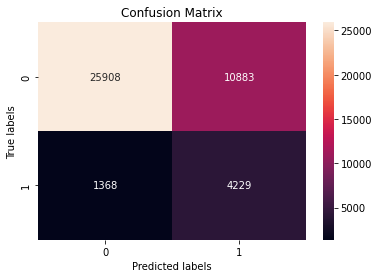

In [9]:
# Model Logistic Regresion (Baseline) Menggunakan hasil bagian 1

print("Model Logistic Regression")
#buat model
logRegModel = LogisticRegression()
#fit model
model_fit(logRegModel)

score(logRegModel)

Model SVM

Model SVC
Accuracy:  0.740516183825611
Precision, Recall, F1:
              precision    recall  f1-score   support

       False       0.96      0.73      0.83     36791
        True       0.32      0.82      0.46      5597

    accuracy                           0.74     42388
   macro avg       0.64      0.78      0.64     42388
weighted avg       0.88      0.74      0.78     42388

AUROC : 0.8502697549493482
Confusion Matrix:


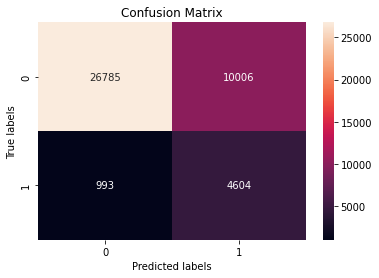

In [10]:
# Model SVC

print("Model SVC")
#buat model
model = SVC(kernel="rbf", random_state=0, probability=True, C=1000, gamma=0.001)
# model = SVC(kernel="rbf", random_state=0)
#fit model
model_fit(model)

score(model)

## 2. Tuning Hyperparameter SVC

In [29]:
#Membuat model
model = SVC(kernel="rbf", random_state=0)
#Membuat parameter
# param = {"C": [0.1, 1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001, 0.0001], "kernel": ["rbf"], "probability":True}
param = {"C": [0.1, 1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001, 0.0001], "kernel": ["rbf"]}
#Membuat grid search
grid = GridSearchCV(model, param, refit=True, verbose=3)
#Melatih model
grid.fit(X_train, y_train)
#Menampilkan hasil terbaik
print(grid.best_params_)
print(grid.best_estimator_)
#Menampilkan hasil prediksi
grid_predictions = grid.predict(X_test)
print("Accuracy :", accuracy_score(y_test, grid_predictions))
print("Precision, Recall, F1:", classification_report(y_test, grid_predictions))
print("AUROC :", roc_auc_score(y_test, grid_predictions))
print("")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.596 total time=   4.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   4.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   4.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   4.7s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   5.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.727 total time=   4.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.728 total time=   4.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.720 total time=   4.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.729 total time=   4.7s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.721 total time=   5.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.754 total time=   4.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

## 3. Improvement (Soft Voting, Hard Voting, Stacking)

Persiapan Model Gabungan

In [19]:
logRegModel = LogisticRegression()
svmModel = SVC(C=0.1, gamma=0.001, random_state=0, probability=True)
models = [('lr',logRegModel),('svm',svmModel)]

Soft Voting

Accuracy:  0.7120411437199208
Precision, Recall, F1:
              precision    recall  f1-score   support

       False       0.95      0.70      0.81     36791
        True       0.28      0.78      0.42      5597

    accuracy                           0.71     42388
   macro avg       0.62      0.74      0.61     42388
weighted avg       0.87      0.71      0.76     42388

AUROC : 0.8176940802643484
Confusion Matrix:


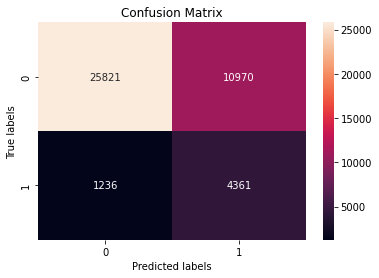

In [13]:
softVoting = VotingClassifier(estimators=models, voting='soft')
model_fit(softVoting)
score(softVoting)

Hard Voting

In [20]:
hardVoting = VotingClassifier(estimators=models, voting='hard')
model_fit(hardVoting)
score(hardVoting)

Accuracy:  0.7308672265735585
Precision, Recall, F1:
              precision    recall  f1-score   support

       False       0.95      0.73      0.82     36791
        True       0.29      0.74      0.42      5597

    accuracy                           0.73     42388
   macro avg       0.62      0.73      0.62     42388
weighted avg       0.86      0.73      0.77     42388



AttributeError: predict_proba is not available when voting='hard'

Stacking

In [ ]:
stacking = StackingClassifier(estimators=models, final_estimator=LogisticRegression())
model_fit(hardVoting)
score(hardVoting)